In [14]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from skimage.feature import hog
%matplotlib inline

In [2]:
vehicle_files = glob.glob('../vehicles/**/*.png')
vehicle_imgs = [cv2.cvtColor(cv2.imread(v), cv2.COLOR_BGR2RGB) for v in vehicle_files]
non_vehicle_files = glob.glob('../non-vehicles/**/*.png')
non_vehicle_imgs = [cv2.cvtColor(cv2.imread(v), cv2.COLOR_BGR2RGB) for v in non_vehicle_files]
num_vehicles, num_non_vehicles = len(vehicle_imgs), len(non_vehicle_imgs)
all_imgs = vehicle_imgs + non_vehicle_imgs

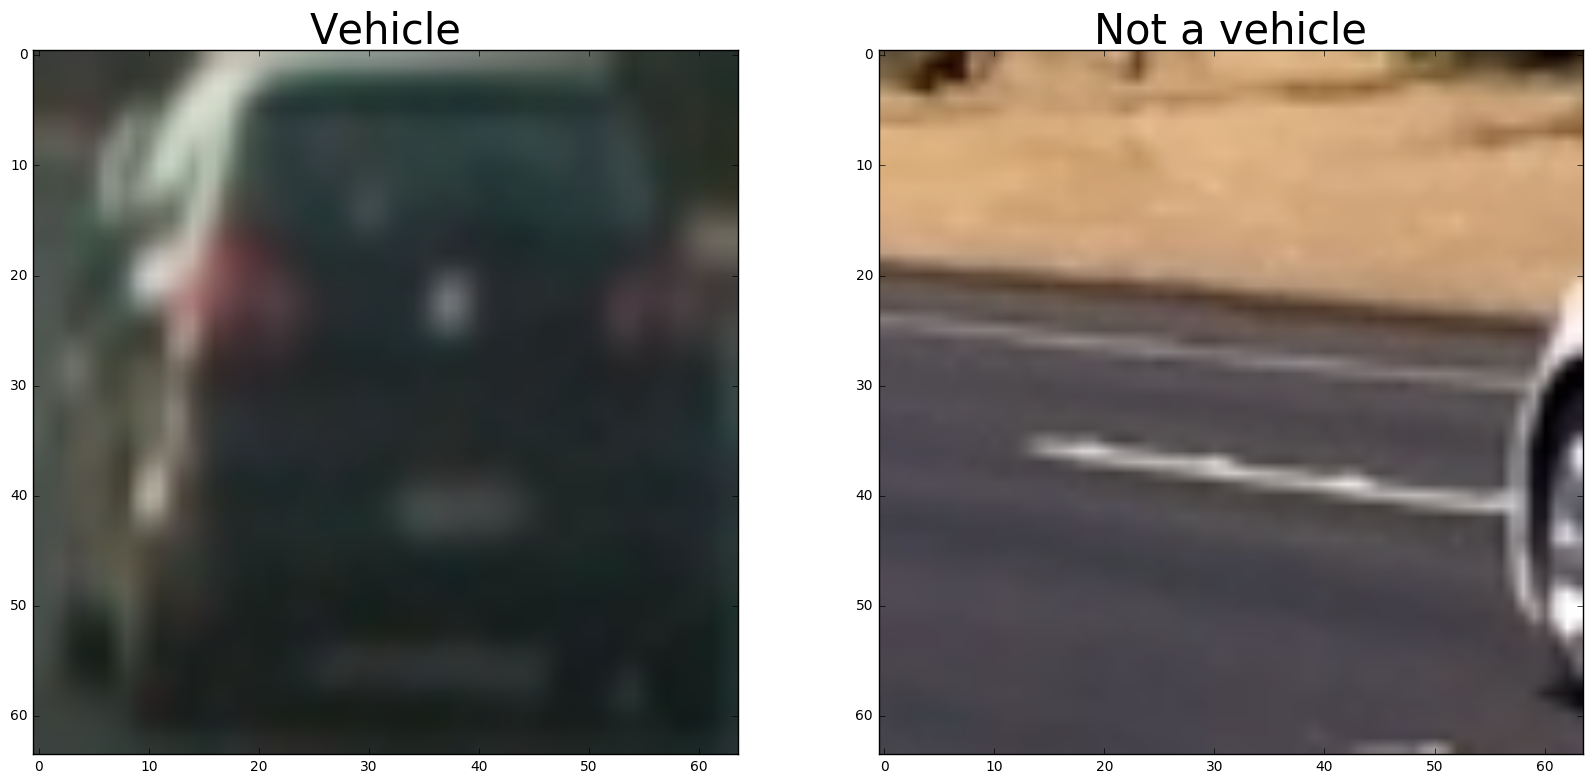

In [3]:
def show_two_images(img1, img2, title1, title2):
    cmap = None if len(img1.shape) == 3 else 'gray'
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2, fontsize=30)

ind1, ind2 = np.random.randint(0, len(non_vehicle_imgs), 2)
show_two_images(vehicle_imgs[ind1], non_vehicle_imgs[ind2], 'Vehicle', 'Not a vehicle')


In [4]:
color_conversions = [cv2.COLOR_RGB2HSV, cv2.COLOR_RGB2LUV, cv2.COLOR_RGB2HLS, cv2.COLOR_RGB2YUV, cv2.COLOR_RGB2YCrCb]
def bin_spatial(img, color_conversion=None, size=(16, 16)):
    # Convert image to new color space (if specified)
    if color_conversion is not None:
        feature_image = cv2.cvtColor(img, color_conversion)
    else:
        feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [5]:
def get_hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, transform_sqrt=False, visualise=False, feature_vector=True)
    hog_features = hog_features.ravel()
    return hog_features

In [6]:
x_list = []
for img in all_imgs:
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    bin_spatial_features = bin_spatial(img_hls, color_conversion=None)
    hog_features_h = get_hog(img_hls[:,:,0])
    hog_features_l = get_hog(img_hls[:,:,1])
    hog_features_s = get_hog(img_hls[:,:,2])
    img_features = np.concatenate((bin_spatial_features, hog_features_h, hog_features_l, hog_features_s))
    x_list.append(img_features)
print(bin_spatial_features.shape, hog_features_h.shape)

(768,) (1764,)


In [7]:
def get_feature_vector(image):
    image_resized = cv2.resize(image, (64, 64), cv2.INTER_AREA)
    image_hls = cv2.cvtColor(image_resized, cv2.COLOR_RGB2HLS)
    bin_spatial_features = bin_spatial(image_hls, color_conversion=None)
    hog_features_h = get_hog(image_hls[:,:,0])
    hog_features_l = get_hog(image_hls[:,:,1])
    hog_features_s = get_hog(image_hls[:,:,2])
    img_features = np.concatenate((bin_spatial_features, hog_features_h, hog_features_l, hog_features_s))
    return img_features

In [8]:
x = np.vstack(x_list).astype(np.float64)
x_scaler = StandardScaler().fit(x)
x = x_scaler.transform(x)
y = np.array([1] * num_vehicles + [0] * num_non_vehicles)
print(x.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

(17760, 6060) (17760,)


In [ ]:
clf = SVC(kernel='rbf', random_state=7)
clf.fit(x_train, y_train) 
print(clf.score(x_test, y_test))

In [9]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [90]:
with open('clf.pickle', 'rb') as f:
    clf = pickle.load(f)

In [100]:
image = cv2.imread('test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
y_start_stop=[int(image.shape[0]/2), int(image.shape[0])]
window_sizes = [(64, 64), (96, 96), (128, 128), (160, 160), (192, 192)]
windows = [] 
for window_size in window_sizes:
    new_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=window_size, 
                               xy_overlap=(0.75, 0.75))
    windows.extend(new_windows)

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)     

[((816, 408), (912, 504)), ((840, 408), (936, 504)), ((1080, 408), (1176, 504)), ((1104, 408), (1200, 504)), ((800, 392), (928, 520)), ((832, 392), (960, 520)), ((1056, 392), (1184, 520)), ((800, 360), (960, 520))]


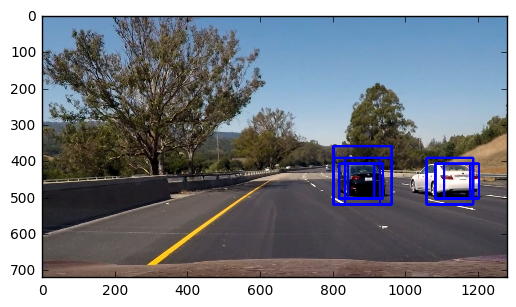

In [101]:
vehicle_windows = []
for window in windows:
    img_section = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    img_section_features = get_feature_vector(img_section)
    img_section_features = x_scaler.transform([img_section_features])[0]
    pred = clf.predict([img_section_features])[0]
    if pred == 1:
        vehicle_windows.append(window)
print(vehicle_windows)
image_vehicles = draw_boxes(image, vehicle_windows, color=(0, 0, 255), thick=6)
plt.imshow(image_vehicles)